In [1]:
#TASK 1

class Node:
    """Node class for chaining."""
    def __init__(self, key, value):
        self.key = key
        self.value = value
        self.next = None

class HashTable:
    def __init__(self, size, method='chaining'):
        self.size = size
        self.method = method
        if method == 'chaining':
            self.table = [None] * size
        elif method == 'probing':
            self.table = [None] * size
            self.tombstone = object()
        else:
            raise ValueError("Method must be 'chaining' or 'probing'")

    def _hash(self, key):
        return hash(key) % self.size

    def insert(self, key, value):
        index = self._hash(key)
        if self.method == 'chaining':
            head = self.table[index]
            while head:
                if head.key == key:
                    head.value = value
                    return
                head = head.next
            new_node = Node(key, value)
            new_node.next = self.table[index]
            self.table[index] = new_node

        elif self.method == 'probing':
            for _ in range(self.size):
                if self.table[index] is None or self.table[index] is self.tombstone:
                    self.table[index] = (key, value)
                    return
                elif self.table[index][0] == key:
                    self.table[index] = (key, value)
                    return
                index = (index + 1) % self.size
            raise Exception("Hash table is full")

    def get(self, key):
        index = self._hash(key)
        if self.method == 'chaining':
            head = self.table[index]
            while head:
                if head.key == key:
                    return head.value
                head = head.next
            return None

        elif self.method == 'probing':
            for _ in range(self.size):
                if self.table[index] is None:
                    return None
                elif self.table[index] is not self.tombstone and self.table[index][0] == key:
                    return self.table[index][1]
                index = (index + 1) % self.size
            return None

    def delete(self, key):
        index = self._hash(key)
        if self.method == 'chaining':
            head = self.table[index]
            prev = None
            while head:
                if head.key == key:
                    if prev:
                        prev.next = head.next
                    else:
                        self.table[index] = head.next
                    return
                prev = head
                head = head.next

        elif self.method == 'probing':
            for _ in range(self.size):
                if self.table[index] is None:
                    return
                elif self.table[index] is not self.tombstone and self.table[index][0] == key:
                    self.table[index] = self.tombstone
                    return
                index = (index + 1) % self.size


In [2]:
#TEST CASE

# Test with chaining
print("Testing Chaining:")
ht_chain = HashTable(10, method='chaining')
ht_chain.insert("name", "Alice")
ht_chain.insert("age", 25)
print(ht_chain.get("name"))  # Output: Alice
ht_chain.delete("age")
print(ht_chain.get("age"))   # Output: None

# Test with linear probing
print("\nTesting Linear Probing:")
ht_probe = HashTable(10, method='probing')
ht_probe.insert("name", "Alice")
ht_probe.insert("age", 25)
print(ht_probe.get("name"))  # Output: Alice
ht_probe.delete("age")
print(ht_probe.get("age"))   # Output: None


Testing Chaining:
Alice
None

Testing Linear Probing:
Alice
None


Custom Hash Collisions: 950
Built-in Hash Collisions: 950


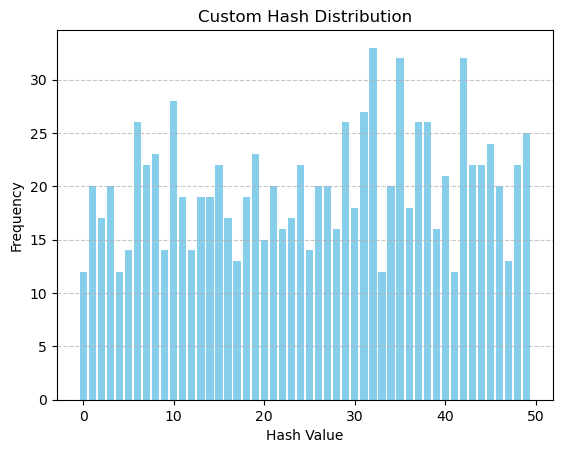

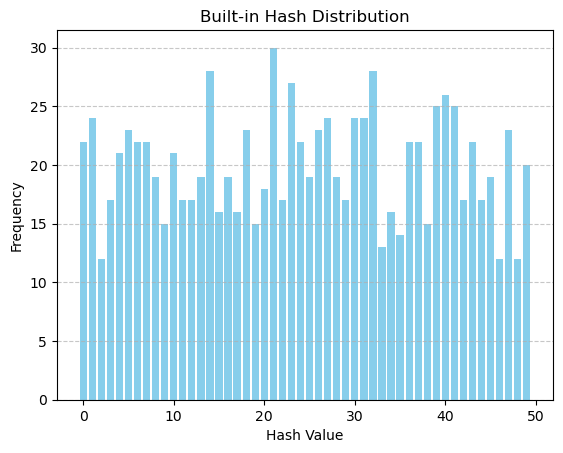

In [3]:
# TASK 2

import matplotlib.pyplot as plt
import random
import string
from collections import defaultdict

# Custom hash function: simple sum-of-ordinals mod table size
def custom_hash(key, table_size):
    return sum(ord(c) for c in key) % table_size

# Compare with Python's built-in hash function
def builtin_hash(key, table_size):
    return hash(key) % table_size

# Generate a list of random string keys
def generate_keys(n, length=8):
    return [''.join(random.choices(string.ascii_letters, k=length)) for _ in range(n)]

# Analyze collisions for a given hash function
def analyze_collisions(hash_func, keys, table_size):
    hash_counts = defaultdict(int)
    collisions = 0
    for key in keys:
        idx = hash_func(key, table_size)
        if hash_counts[idx] > 0:
            collisions += 1
        hash_counts[idx] += 1
    return collisions, hash_counts

# Plot distribution
def plot_distribution(hash_counts, title):
    indices = list(hash_counts.keys())
    values = [hash_counts[i] for i in indices]

    plt.bar(indices, values, color='skyblue')
    plt.xlabel('Hash Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Parameters
NUM_KEYS = 1000
TABLE_SIZE = 50
keys = generate_keys(NUM_KEYS)

# Analyze custom hash
custom_collisions, custom_counts = analyze_collisions(custom_hash, keys, TABLE_SIZE)
print(f"Custom Hash Collisions: {custom_collisions}")

# Analyze built-in hash
builtin_collisions, builtin_counts = analyze_collisions(builtin_hash, keys, TABLE_SIZE)
print(f"Built-in Hash Collisions: {builtin_collisions}")

# Plot
plot_distribution(custom_counts, "Custom Hash Distribution")
plot_distribution(builtin_counts, "Built-in Hash Distribution")


In [4]:
# TASK 3

class Node:
    def __init__(self, key, value):
        self.key = key
        self.value = value
        self.prev = None
        self.next = None

class LRUCache:
    def __init__(self, capacity):
        self.capacity = capacity
        self.cache = {}  # Hash table: key -> node
        self.head = Node(0, 0)  # Dummy head
        self.tail = Node(0, 0)  # Dummy tail
        self.head.next = self.tail
        self.tail.prev = self.head

    def _remove(self, node):
        """Remove node from the doubly linked list."""
        prev, nxt = node.prev, node.next
        prev.next = nxt
        nxt.prev = prev

    def _add_to_front(self, node):
        """Insert node right after head (most recently used)."""
        node.next = self.head.next
        node.prev = self.head
        self.head.next.prev = node
        self.head.next = node

    def get(self, key):
        if key in self.cache:
            node = self.cache[key]
            self._remove(node)         # Move to front
            self._add_to_front(node)
            return node.value
        return -1

    def put(self, key, value):
        if key in self.cache:
            self._remove(self.cache[key])
        node = Node(key, value)
        self._add_to_front(node)
        self.cache[key] = node

        if len(self.cache) > self.capacity:
            # Remove LRU from end
            lru = self.tail.prev
            self._remove(lru)
            del self.cache[lru.key]


In [5]:
# TEST CASE 

cache = LRUCache(2)
cache.put(1, "A")
cache.put(2, "B")
print(cache.get(1))    # Output: "A"
cache.put(3, "C")      # Removes key 2 (least recently used)
print(cache.get(2))    # Output: -1
print(cache.get(3))    # Output: "C"


A
-1
C
